In [27]:
import torch
import torch.nn as nn
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [28]:
# Utility function to compare different uncertainty measures
def compare_measures(m1, m2, name1, name2, ax=None):
    """
    Compute correlation and plot joint distribution between two measures.

    Args:
        m1, m2: Measures to compare
        name1, name2: Names of the measures for plotting
        ax: Matplotlib axis for plotting (if None, uses current axis)

    Returns:
        Correlation value
    """
    m1 = m1.flatten()
    m2 = m2.flatten()

    # Compute the correlation
    correlation = torch.corrcoef(torch.stack((m2, m1)))[0, 1]
    print(f"Correlation between {name1} and {name2}: {correlation.item():.4f}")

    # If no axis provided, use the current axis
    if ax is not None:
        # Create a scatter plot
        ax.scatter(m1, m2, alpha=0.5, s=10)
        ax.set_xlabel(name1)
        ax.set_ylabel(name2)
        ax.set_title(f"Correlation: {correlation.item():.4f}")

        # Add a trend line
        z = np.polyfit(m1.numpy(), m2.numpy(), 1)
        p = np.poly1d(z)
        x_range = np.linspace(m1.min().item(), m1.max().item(), 100)
        ax.plot(x_range, p(x_range), "r--", alpha=0.8)

    return correlation.item()

In [29]:
# Model class definitions
class SimpleModel(nn.Module):
    """Simple logistic regression model."""

    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.layer_1(x))
        return x

    def get_logits(self, x):
        return self.layer_1(x)

    def parameters_as_vector(self):
        params = []
        for param in self.parameters():
            params.append(param.data.view(-1))
        return torch.cat(params)

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters())

In [30]:
class ComplexModel(nn.Module):
    """More complex model with hidden layers."""

    def __init__(self, hidden_size=32):
        super().__init__()
        self.layer_1 = nn.Linear(2, hidden_size)
        self.layer_2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.layer_1(x))
        x = self.sigmoid(self.layer_2(x))
        return x

    def get_logits(self, x):
        x = self.sigmoid(self.layer_1(x))
        return self.layer_2(x)

    def parameters_as_vector(self):
        params = []
        for param in self.parameters():
            params.append(param.data.view(-1))
        return torch.cat(params)

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters())

In [31]:
# Laplace approximation functions
def compute_hessian_diagonal(model, data_x, data_y, prior_precision=1.0):
    """
    Compute diagonal Hessian approximation using Fisher Information Matrix.

    Args:
        model: PyTorch model
        data_x: Input features
        data_y: Target values
        prior_precision: L2 regularization strength

    Returns:
        Diagonal of Hessian matrix
    """
    n_params = model.count_parameters()
    hessian_diag = torch.zeros(n_params)

    # Use Fisher Information Matrix (FIM) approximation for the Hessian
    for x, y in zip(data_x, data_y):
        x = x.unsqueeze(0)  # Add batch dimension
        model.zero_grad()

        # Get logits
        logits = model.get_logits(x)
        prob = torch.sigmoid(logits)

        # Compute gradient of log-likelihood w.r.t parameters
        loss = -torch.log(prob) if y > 0.5 else -torch.log(1 - prob)
        loss.backward()

        # Extract gradients
        grads = []
        for param in model.parameters():
            if param.grad is not None:
                grads.append(param.grad.view(-1))
        grads = torch.cat(grads)

        # Outer product of gradients approximates the Hessian
        hessian_diag += grads * grads

    # Add prior precision (regularization)
    hessian_diag += prior_precision

    return hessian_diag

In [32]:
def laplace_predict(model, x_test, posterior_variance, samples=100):
    """
    Perform prediction using Laplace approximation.

    Args:
        model: PyTorch model
        x_test: Test data
        posterior_variance: Variance of posterior distribution
        samples: Number of Monte Carlo samples

    Returns:
        Mean and variance of predictions
    """
    n_test = len(x_test)

    # Store predictions from all samples
    all_preds = torch.zeros(samples, n_test)

    # Get MAP weights
    map_weights = model.parameters_as_vector()

    # Sample from posterior
    for i in range(samples):
        # Sample weights from Gaussian posterior
        sampled_weights = map_weights + torch.randn_like(map_weights) * torch.sqrt(
            posterior_variance
        )

        # Apply sampled weights to model
        idx = 0
        for param in model.parameters():
            param_size = param.numel()
            param.data = sampled_weights[idx : idx + param_size].reshape(param.shape)
            idx += param_size

        # Predict
        with torch.no_grad():
            all_preds[i] = model(x_test).squeeze()

    # Restore MAP weights
    idx = 0
    for param in model.parameters():
        param_size = param.numel()
        param.data = map_weights[idx : idx + param_size].reshape(param.shape)
        idx += param_size

    # Compute mean prediction and variance
    pred_mean = all_preds.mean(0)
    pred_var = all_preds.var(0)

    return pred_mean, pred_var

In [33]:
def get_grad_norm(model, loss_fn, x, y):
    """
    Compute the norm of the gradient.

    Args:
        model: PyTorch model
        loss_fn: Loss function
        x: Input data
        y: Target

    Returns:
        Norm of gradient
    """
    model.zero_grad()
    loss = loss_fn(model(x), y)
    loss.backward()

    grads = []
    for name, param in model.named_parameters():
        if param.grad is not None:
            grads.append(param.grad.flatten())

    return torch.norm(torch.cat(grads))

In [34]:
def get_grad_norm_grid(model, loss_fn, samples, permute=lambda x: x):
    """
    Compute gradient norms across a grid of samples.

    Args:
        model: PyTorch model
        loss_fn: Loss function
        samples: Grid samples
        permute: Function to permute predictions

    Returns:
        Tensor of gradient norms
    """
    viz_grad = []

    for x in samples:
        viz_grad.append(
            get_grad_norm(
                model,
                loss_fn,
                x.reshape(1, -1),
                permute(model(x.reshape(1, -1)).round()),
            )
        )

    return torch.tensor(viz_grad)

In [35]:
def plot_decision_boundary_and_uncertainty(
    model, X, y, posterior_variance, criterion, title_prefix=""
):
    """
    Plot decision boundary and uncertainty measures.

    Args:
        model: PyTorch model
        X: Features
        y: Targets
        posterior_variance: Variance of posterior distribution
        criterion: Loss function
        title_prefix: Prefix for plot titles
    """
    # Create a grid for visualization
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

    # Evaluate model on the grid
    grid = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    grid_mean, grid_var = laplace_predict(model, grid, posterior_variance)
    grid_mean = grid_mean.reshape(xx.shape)
    grid_var = grid_var.reshape(xx.shape)
    grid_std = torch.sqrt(grid_var)

    # Compute gradient uncertainty measures
    gradient_uncertainty = get_grad_norm_grid(model, criterion, grid).reshape(xx.shape)
    gradient_uncertainty_flipped = get_grad_norm_grid(
        model, criterion, grid, lambda x: 1 - x
    ).reshape(xx.shape)

    # Plotting
    plt.figure(figsize=(30, 6))

    # Plot decision boundary
    plt.subplot(1, 4, 1)
    plt.contourf(
        xx,
        yy,
        grid_mean.numpy(),
        alpha=0.8,
        cmap=plt.cm.RdBu,
        levels=np.linspace(0, 1, 11),
    )
    plt.scatter(X[:, 0], X[:, 1], c=y.squeeze(), cmap=plt.cm.RdBu_r, edgecolors="k")
    plt.title(f"{title_prefix}Decision Boundary")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.colorbar(label="Probability")

    # Plot Laplace uncertainty
    plt.subplot(1, 4, 2)
    plt.contourf(xx, yy, grid_std.numpy(), alpha=0.8, cmap="viridis")
    plt.scatter(X[:, 0], X[:, 1], c=y.squeeze(), cmap=plt.cm.RdBu_r, edgecolors="k")
    plt.title(f"{title_prefix}Predictive Uncertainty (Laplace)")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.colorbar(label="Standard Deviation")

    # Plot gradient uncertainty
    plt.subplot(1, 4, 3)
    plt.contourf(xx, yy, gradient_uncertainty.numpy(), alpha=0.8, cmap="viridis")
    plt.scatter(X[:, 0], X[:, 1], c=y.squeeze(), cmap=plt.cm.RdBu_r, edgecolors="k")
    plt.title(f"{title_prefix}Gradient Uncertainty")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.colorbar()

    # Plot flipped gradient uncertainty
    plt.subplot(1, 4, 4)
    plt.contourf(
        xx, yy, gradient_uncertainty_flipped.numpy(), alpha=0.8, cmap="viridis"
    )
    plt.scatter(X[:, 0], X[:, 1], c=y.squeeze(), cmap=plt.cm.RdBu_r, edgecolors="k")
    plt.title(f"{title_prefix}Gradient Uncertainty (Flipped)")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.colorbar()

    plt.tight_layout()
    plt.show()

    return grid_mean, grid_std, gradient_uncertainty, gradient_uncertainty_flipped

In [36]:
def run_experiment(
    X,
    y,
    model_class,
    model_args=None,
    train_method="adam",
    prior_precision=0.01,
    epochs=1000,
    title_prefix="",
    verbose=True,
):
    """
    Run an experiment with Laplace approximation.

    Args:
        X: Features
        y: Targets
        model_class: Class of model to use
        model_args: Arguments for model initialization
        train_method: Method to train the model ("adam" or "sklearn")
        prior_precision: L2 regularization strength
        epochs: Number of training epochs
        title_prefix: Prefix for plot titles
        verbose: Whether to print progress

    Returns:
        Trained model, test accuracy, and uncertainty metrics
    """
    if model_args is None:
        model_args = {}

    # Convert to torch tensors
    X = torch.Tensor(X)
    y = torch.Tensor(y).reshape(-1, 1)

    # Split data
    train_x, test_x, train_y, test_y = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Create model
    model = model_class(**model_args)
    criterion = nn.BCELoss()

    # Train the model
    if train_method == "adam":
        # Train with Adam optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

        for epoch in range(epochs):
            # Forward pass
            outputs = model(train_x)
            loss = criterion(outputs, train_y)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if verbose and (epoch + 1) % (epochs // 10) == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

    elif train_method == "sklearn":
        # Train with scikit-learn
        X_train_np = train_x.numpy()
        y_train_np = train_y.numpy().ravel()  # flatten the targets

        # Train logistic regression
        logistic_model = LogisticRegression(fit_intercept=True, solver="lbfgs")
        logistic_model.fit(X_train_np, y_train_np)

        # Get the weights and bias
        weights = logistic_model.coef_
        bias = logistic_model.intercept_

        # Apply these weights to PyTorch model
        with torch.no_grad():
            model.layer_1.weight.copy_(torch.tensor(weights))
            model.layer_1.bias.copy_(torch.tensor(bias))

    # Compute Hessian diagonal
    hessian_diag = compute_hessian_diagonal(model, train_x, train_y, prior_precision)

    # Compute posterior precision and covariance
    posterior_precision = hessian_diag
    posterior_variance = 1.0 / (
        posterior_precision + 1e-6
    )  # Add small constant for numerical stability

    # Make predictions with uncertainty
    pred_mean, pred_var = laplace_predict(model, test_x, posterior_variance)

    # Calculate accuracy
    correct = ((pred_mean > 0.5) == test_y.squeeze()).float().mean()
    if verbose:
        print(f"Accuracy: {correct.item():.4f}")
        print(f"Average predictive uncertainty: {pred_var.mean().item():.4f}")

    # Plot results
    grid_mean, grid_std, grad_uncertainty, grad_uncertainty_flipped = (
        plot_decision_boundary_and_uncertainty(
            model, X, y, posterior_variance, criterion, title_prefix
        )
    )

    # Plot correlations between different uncertainty measures
    plt.figure(figsize=(20, 5))

    # Create subplots for correlations
    ax1 = plt.subplot(1, 4, 1)
    ax2 = plt.subplot(1, 4, 2)
    ax3 = plt.subplot(1, 4, 3)
    ax4 = plt.subplot(1, 4, 4)

    # Compare different uncertainty measures
    compare_measures(
        grid_std, grad_uncertainty, "grid_std", "gradient_uncertainty", ax1
    )
    compare_measures(
        grid_std,
        grad_uncertainty_flipped,
        "grid_std",
        "gradient_uncertainty_flipped",
        ax2,
    )
    compare_measures(
        abs(grid_mean - 0.5) * 2,
        grad_uncertainty,
        "prediction_confidence",
        "gradient_uncertainty",
        ax3,
    )
    compare_measures(
        abs(grid_mean - 0.5) * 2,
        grad_uncertainty_flipped,
        "prediction_confidence",
        "gradient_uncertainty_flipped",
        ax4,
    )

    plt.tight_layout()
    plt.show()

    return model, correct.item(), pred_var.mean().item()

Experiment 1: Linear blobs with a simple model (Adam training)
Epoch [100/1000], Loss: 0.0356
Epoch [200/1000], Loss: 0.0215
Epoch [300/1000], Loss: 0.0163
Epoch [400/1000], Loss: 0.0135
Epoch [500/1000], Loss: 0.0118
Epoch [600/1000], Loss: 0.0106
Epoch [700/1000], Loss: 0.0097
Epoch [800/1000], Loss: 0.0091
Epoch [900/1000], Loss: 0.0085
Epoch [1000/1000], Loss: 0.0081
Accuracy: 1.0000
Average predictive uncertainty: 0.0017


/var/folders/f5/0n6l0yh12yggft3np84h1xxr0000gn/T/ipykernel_65140/2926880903.py:18: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))


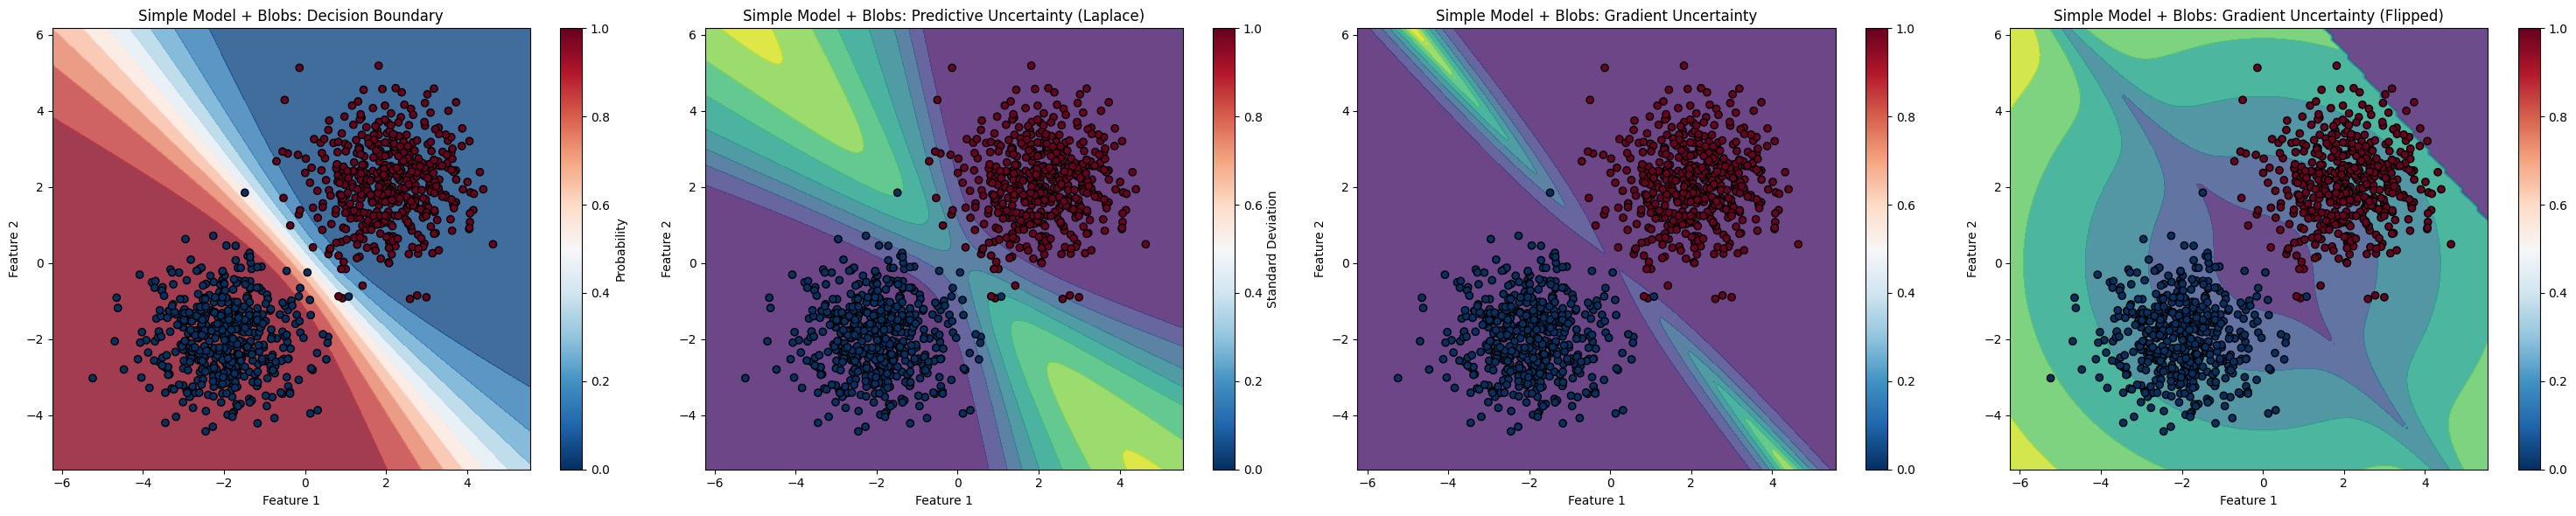

Correlation between grid_std and gradient_uncertainty: 0.6597
Correlation between grid_std and gradient_uncertainty_flipped: 0.1498
Correlation between prediction_confidence and gradient_uncertainty: -0.8270
Correlation between prediction_confidence and gradient_uncertainty_flipped: 0.0448


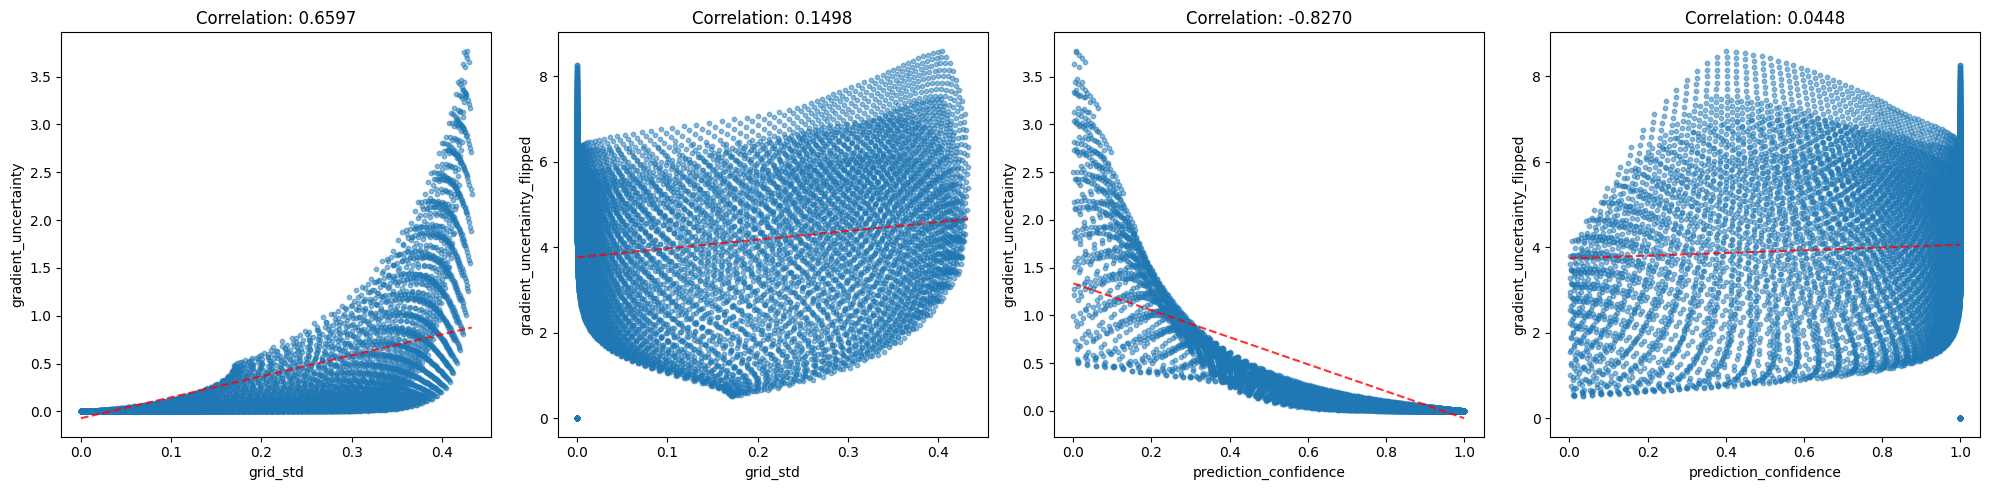

In [37]:
# Experiment 1: Linearly separable blobs with a simple model
print("Experiment 1: Linear blobs with a simple model (Adam training)")
X_blobs, y_blobs = make_blobs(
    n_samples=1000, centers=[[-2, -2], [2, 2]], n_features=2, random_state=42
)
ex1 = run_experiment(
    X_blobs,
    y_blobs,
    SimpleModel,
    train_method="adam",
    title_prefix="Simple Model + Blobs: ",
)


Experiment 2: Linear blobs with a simple model (sklearn training)
Accuracy: 1.0000
Average predictive uncertainty: 0.0015


/var/folders/f5/0n6l0yh12yggft3np84h1xxr0000gn/T/ipykernel_65140/2926880903.py:18: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))


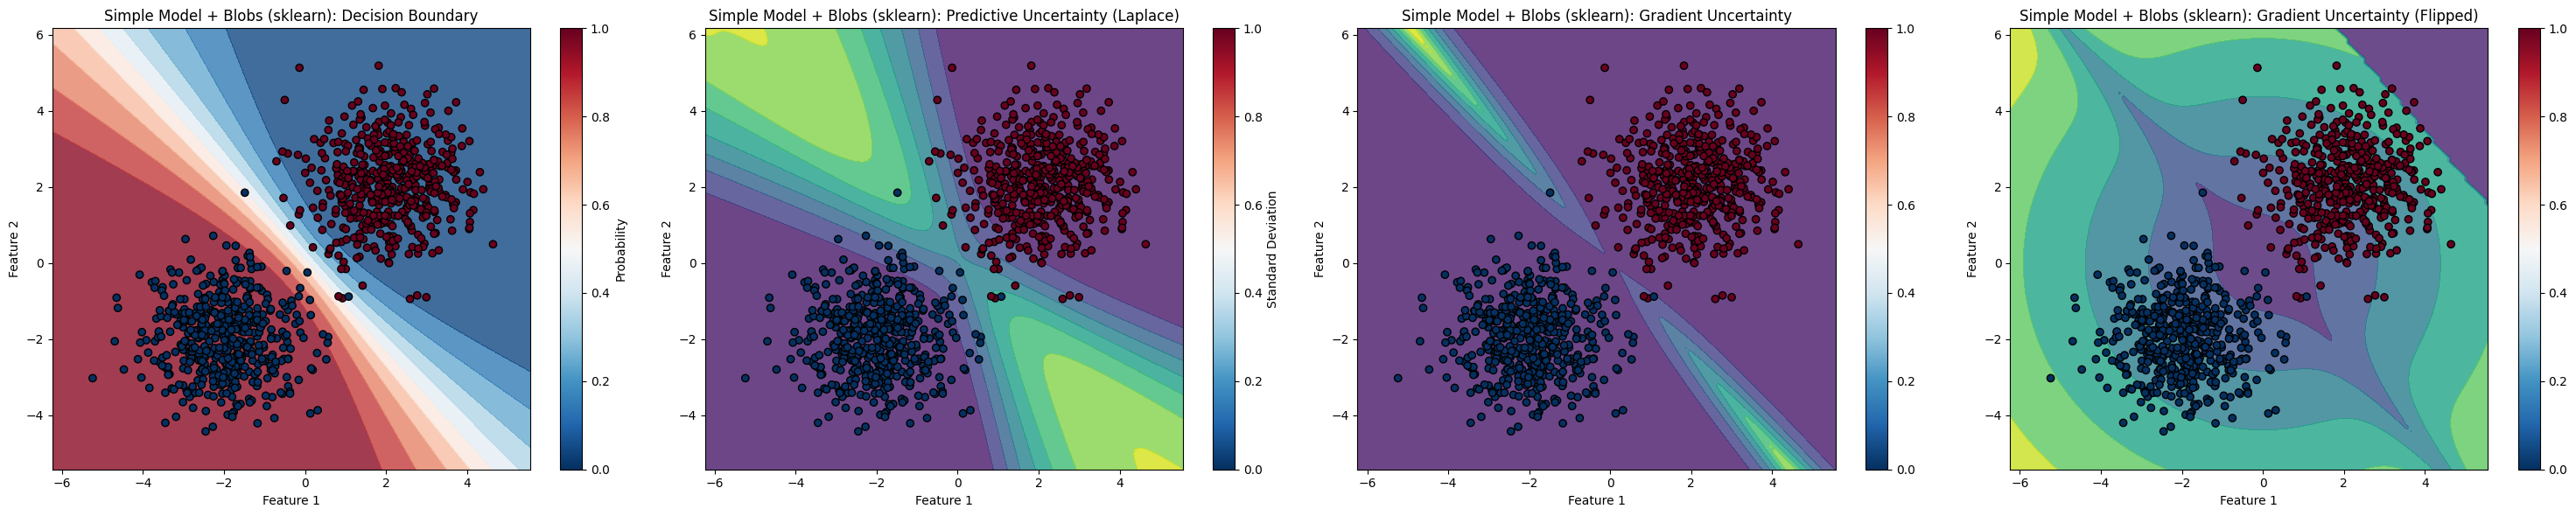

Correlation between grid_std and gradient_uncertainty: 0.6421
Correlation between grid_std and gradient_uncertainty_flipped: 0.1228
Correlation between prediction_confidence and gradient_uncertainty: -0.8023
Correlation between prediction_confidence and gradient_uncertainty_flipped: 0.0554


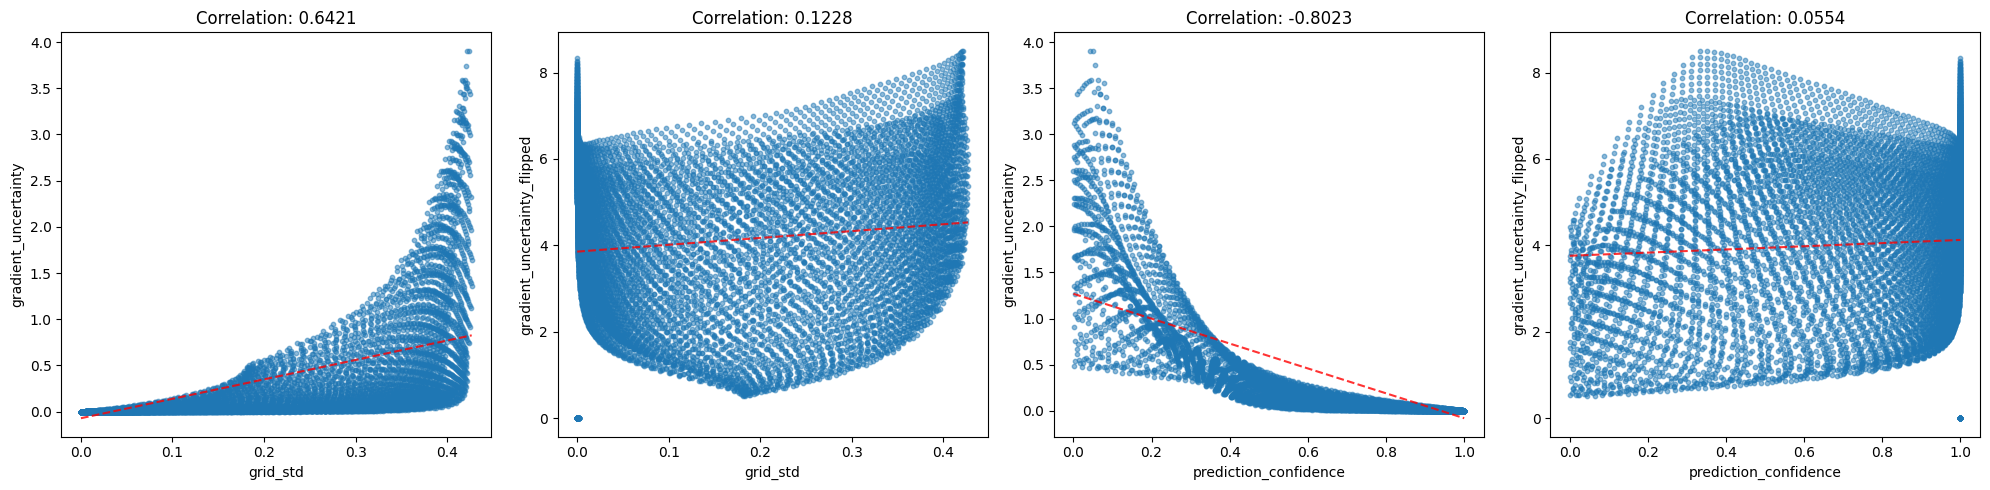

In [38]:
# Experiment 2: Linearly separable blobs with a simple model trained via sklearn
print("\nExperiment 2: Linear blobs with a simple model (sklearn training)")
ex2 = run_experiment(
    X_blobs,
    y_blobs,
    SimpleModel,
    train_method="sklearn",
    title_prefix="Simple Model + Blobs (sklearn): ",
)


Experiment 3: Moon dataset with a complex model
Epoch [200/2000], Loss: 0.2508
Epoch [400/2000], Loss: 0.1275
Epoch [600/2000], Loss: 0.0455
Epoch [800/2000], Loss: 0.0210
Epoch [1000/2000], Loss: 0.0124
Epoch [1200/2000], Loss: 0.0085
Epoch [1400/2000], Loss: 0.0064
Epoch [1600/2000], Loss: 0.0050
Epoch [1800/2000], Loss: 0.0041
Epoch [2000/2000], Loss: 0.0034
Accuracy: 0.6450
Average predictive uncertainty: 0.2344


/var/folders/f5/0n6l0yh12yggft3np84h1xxr0000gn/T/ipykernel_65140/2926880903.py:18: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))


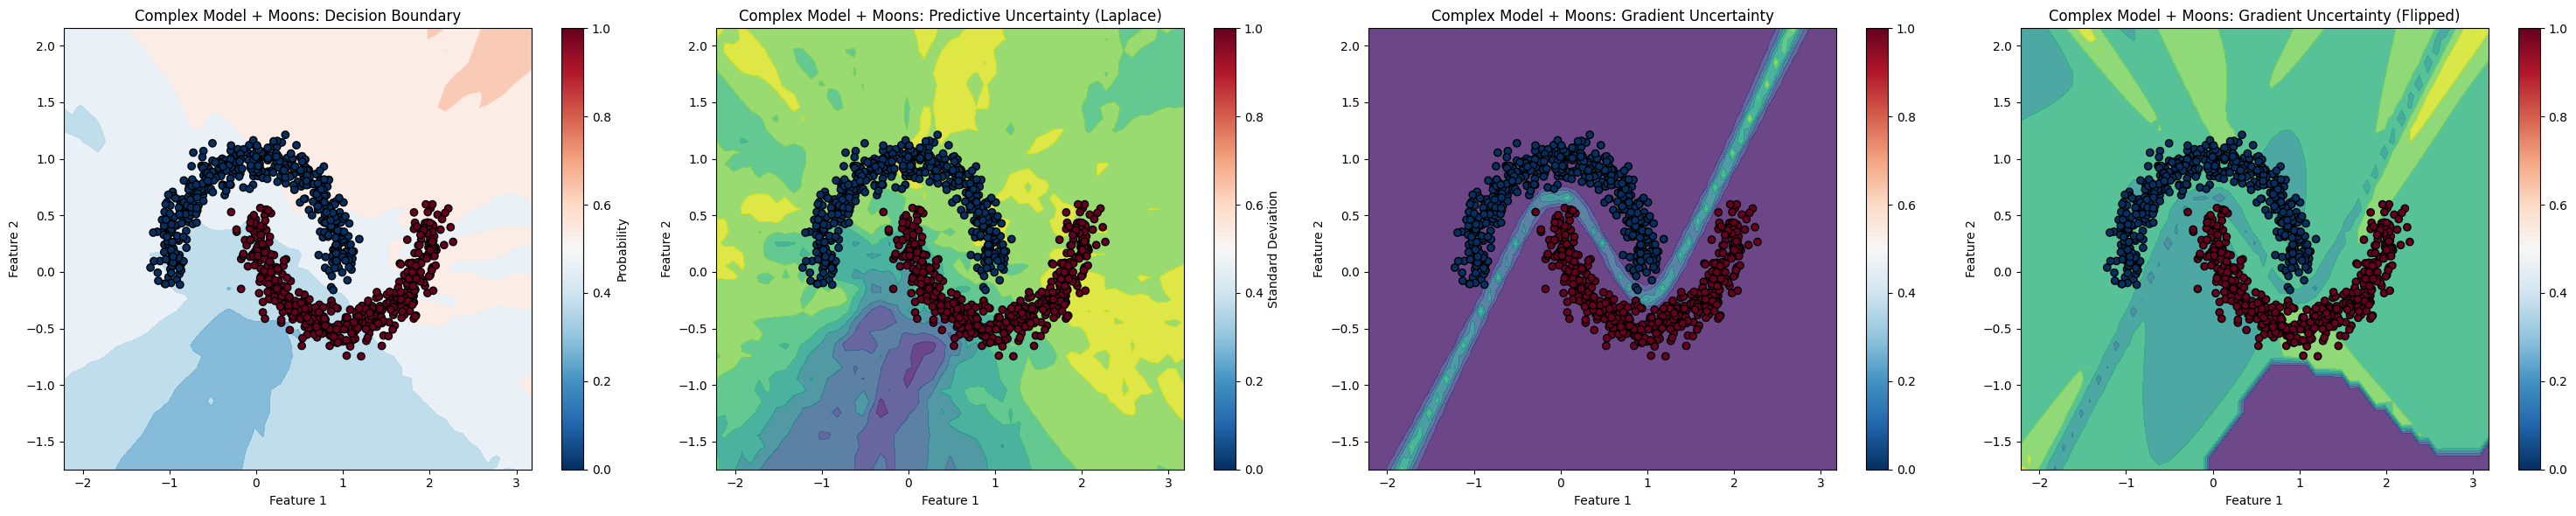

Correlation between grid_std and gradient_uncertainty: -0.0323
Correlation between grid_std and gradient_uncertainty_flipped: 0.2469
Correlation between prediction_confidence and gradient_uncertainty: 0.0432
Correlation between prediction_confidence and gradient_uncertainty_flipped: -0.3567


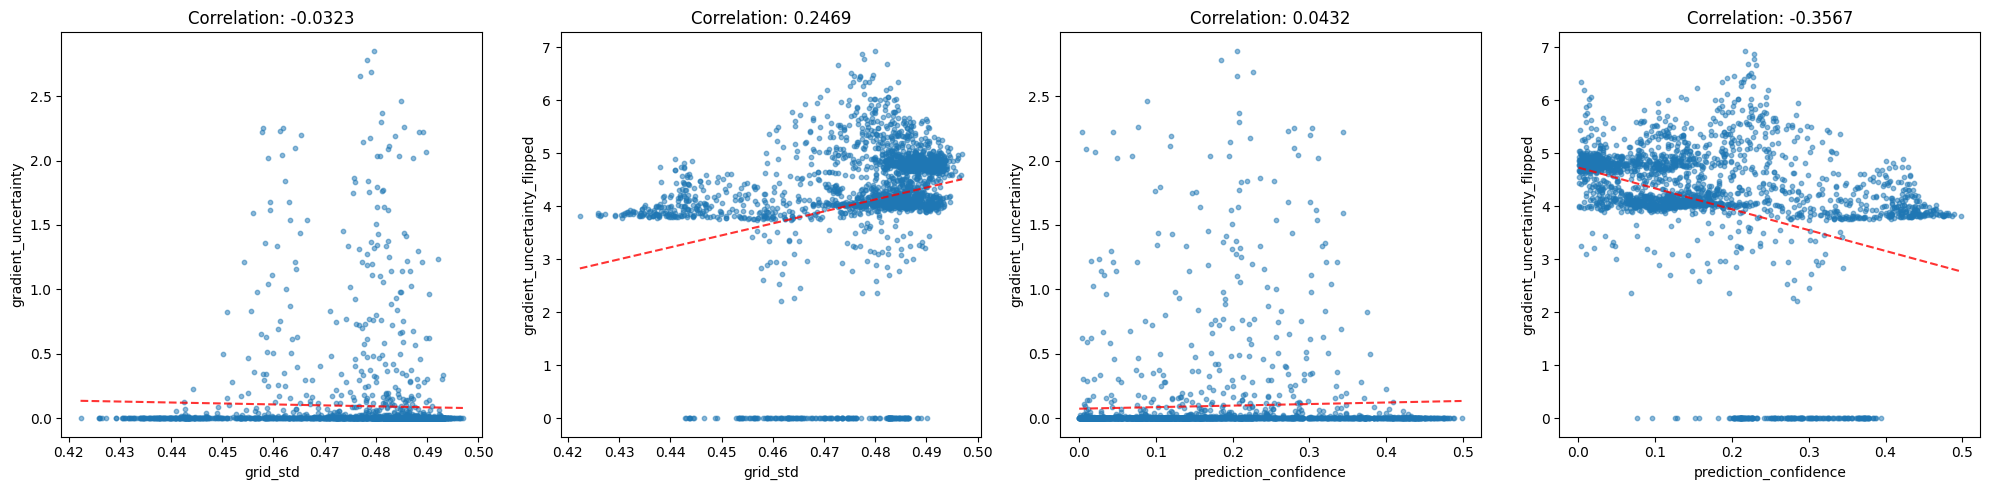

In [41]:
# Experiment 3: Moon dataset with a complex model
print("\nExperiment 3: Moon dataset with a complex model")
X_moons, y_moons = make_moons(n_samples=1000, noise=0.1, random_state=42)
ex3 = run_experiment(
    X_moons,
    y_moons,
    ComplexModel,
    {"hidden_size": 32},
    epochs=2000,
    prior_precision=0.001,
    title_prefix="Complex Model + Moons: ",
)